In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [4]:

def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    app = 0
    # train
    torch.set_default_dtype(torch.float64)
    for key, values in train.items():
        for app in range(len(appliances)):
            df = pd.read_csv(
                f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()
            

            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."

            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)
            if app == 0:
                x = df[appliances[app]].values
            else:
                print(app)
                x += df[appliances[app]].values
            if appliances[app] == "Refrigerator":
                y = df[appliances[app]].values
            # x = df["main"].values
            
        
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_train.extend(torch.tensor(x))
        y_train.extend(torch.tensor(y))
        x_train_timestamp.extend(torch.tensor(timestamp_train))


    x_train = torch.tensor(x_train).reshape(-1, 1)
    y_train = torch.tensor(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)



    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    app = 0
    for key, values in test.items():
        for app in range(len(appliances)):
            df = pd.read_csv(
                f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."

            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)
            if app == 0:
                x = df[appliances[app]].values
            else:
                print(app)
                x += df[appliances[app]].values
            if appliances[app] == "Refrigerator":
                y = df[appliances[app]].values
            # x = df["main"].values
            # y = df[appliances[app]].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_test.extend(torch.tensor(x))
        y_test.extend(torch.tensor(y))
        x_test_timestamp.extend(timestamp)

    x_test = torch.tensor(x_test).reshape(-1, 1)
    y_test = torch.tensor(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)

    x_train = torch.tensor(x_train).reshape(x_train.shape[0], 1).to(torch.float64)
    y_train = torch.tensor(y_train).reshape(-1,).to(torch.float64)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1).to(torch.float64)
    x_test = torch.tensor(x_test).reshape(x_test.shape[0], 1).to(torch.float64)
    y_test = torch.tensor(y_test).reshape(-1,).to(torch.float64)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float64)


    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time


In [5]:
train ={1:{
                    'start_time': "2011-04-28" ,
                    'end_time': "2011-05-15"
                },
        3: {
                'start_time': "2011-04-19" ,
                'end_time': "2011-05-22"
            }
                }
test = { 2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                }

# 6: {
#                     'start_time': "2011-05-25" ,
#                     'end_time': "2011-06-13"
#                 }

# 5: {
#                     'start_time': "2011-04-22" ,
#                     'end_time': "2011-06-01"
#                 }
appliances = ["Microwave", "Refrigerator",  "Dish Washer"] #

In [6]:
appliances[2]

'Dish Washer'

In [7]:
x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time = dataset_load(appliances, train, test)

1
2
1
2
1
2


/tmp/ipykernel_1381258/2144464658.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).reshape(-1,).to(torch.float64)


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

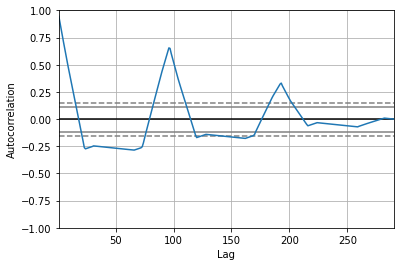

In [34]:
pd.plotting.autocorrelation_plot(pd.Series(x_train[:290].reshape(-1,)))

In [8]:
x_train.shape, x_train_timestamp.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([24918, 1]),
 torch.Size([24918, 1]),
 torch.Size([15656, 1]),
 torch.Size([24918]),
 torch.Size([15656]))

Text(0.5, 0, 'Timestamp Train')

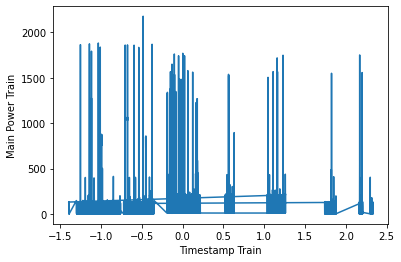

In [35]:
plt.plot(x_train_timestamp, scaler_x.inverse_transform(x_train.reshape(-1,1)))
plt.ylabel(f"Main Power Train")
plt.xlabel(f"Timestamp Train")

Text(0.5, 0, 'Timestamp Train')

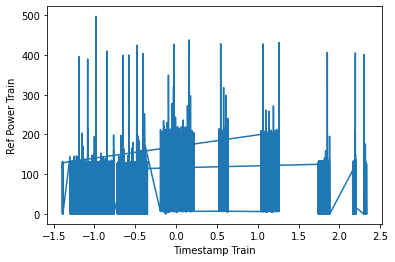

In [36]:
plt.plot(x_train_timestamp, scaler_y.inverse_transform(y_train.reshape(-1,1)))
plt.ylabel(f"Ref Power Train")
plt.xlabel(f"Timestamp Train")

Text(0.5, 0, 'Timestamp Test')

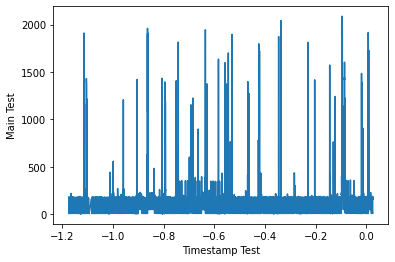

In [37]:
plt.plot(x_test_timestamp, scaler_x.inverse_transform(x_test.reshape(-1,1)))

plt.ylabel(f"Main Test")
plt.xlabel(f"Timestamp Test")

Text(0.5, 0, 'Timestamp test')

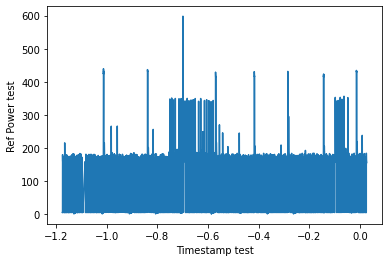

In [38]:
plt.plot(x_test_timestamp, y_test)
plt.ylabel(f"Ref Power test")
plt.xlabel(f"Timestamp test")

Text(0, 0.5, 'Fridge Train Power')

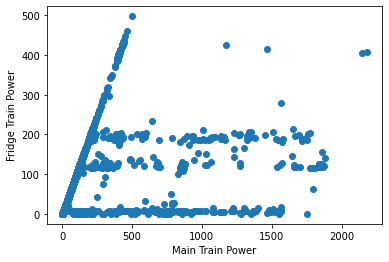

In [39]:
plt.scatter( scaler_x.inverse_transform(x_train), scaler_y.inverse_transform(y_train.reshape(-1,1)))
plt.xlabel("Main Train Power")
plt.ylabel("Fridge Train Power")

Text(0, 0.5, 'Fridge test Power')

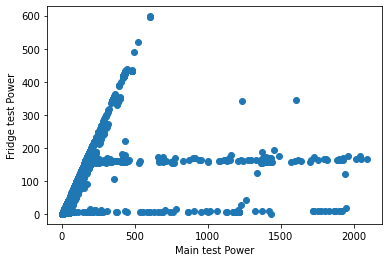

In [40]:
plt.scatter( scaler_x.inverse_transform(x_test),y_test.reshape(-1,1))
plt.xlabel("Main test Power")
plt.ylabel("Fridge test Power")

In [15]:
x_train_full = torch.cat((x_train, x_train_timestamp), dim=1)
x_test_full = torch.cat((x_test, x_test_timestamp), dim=1)
x_train_full.shape, x_test_full.shape

(torch.Size([24918, 2]), torch.Size([15656, 2]))

/tmp/ipykernel_1381258/519887521.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_trans = torch.tensor(torch.tensor(scaler_x.transform(y_test.reshape(-1,1))).reshape(-1,)).contiguous().to(torch.float64)


restart: 0, epoch: 1, iter: 1, loss: 0.8087
restart: 0, epoch: 2, iter: 1, loss: 0.8084


/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


restart: 0, epoch: 3, iter: 1, loss: 0.8081
restart: 0, epoch: 4, iter: 1, loss: 0.8077
restart: 0, epoch: 5, iter: 1, loss: 0.8074
restart: 0, epoch: 6, iter: 1, loss: 0.8071
restart: 0, epoch: 7, iter: 1, loss: 0.8068
restart: 0, epoch: 8, iter: 1, loss: 0.8064
restart: 0, epoch: 9, iter: 1, loss: 0.8061
restart: 0, epoch: 10, iter: 1, loss: 0.8058
restart: 0, epoch: 11, iter: 1, loss: 0.8055
restart: 0, epoch: 12, iter: 1, loss: 0.8051
restart: 0, epoch: 13, iter: 1, loss: 0.8048
restart: 0, epoch: 14, iter: 1, loss: 0.8045
restart: 0, epoch: 15, iter: 1, loss: 0.8042
restart: 0, epoch: 16, iter: 1, loss: 0.8038
restart: 0, epoch: 17, iter: 1, loss: 0.8035
restart: 0, epoch: 18, iter: 1, loss: 0.8032
restart: 0, epoch: 19, iter: 1, loss: 0.8029
restart: 0, epoch: 20, iter: 1, loss: 0.8026
restart: 0, epoch: 21, iter: 1, loss: 0.8022
restart: 0, epoch: 22, iter: 1, loss: 0.8019
restart: 0, epoch: 23, iter: 1, loss: 0.8016
restart: 0, epoch: 24, iter: 1, loss: 0.8013
restart: 0, epoch

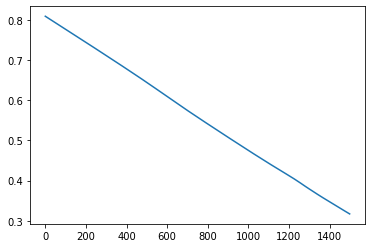

In [16]:
mae_arr =[]
rms_arr = []
y_pred_arr = []

batch = 512

# x_train = x_train[:4500]
# y_train = y_train[:4500]

y_test_trans = torch.tensor(torch.tensor(scaler_x.transform(y_test.reshape(-1,1))).reshape(-1,)).contiguous().to(torch.float64)
for i in range(1):


  kernel1 = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(0))) #nu=2.5,
  kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(1)))
  kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1, active_dims=(1)))
  # kernel4 = ScaleKernel(PeriodicKernel(ard_num_dims=2, active_dims=(0)))
  # kernel5 = ScaleKernel(CosineKernel(ard_num_dims=2, active_dims=(1)))

  kernel = kernel1 + kernel2*kernel3
  # induce_points = 512
  inducing_points =  x_train_full[np.arange(0,x_train_full.shape[0],20)] 
  #x_train_full[torch.randperm(x_train_full.shape[0])[: batch]].to("cuda")
  
  model = SGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel,
                       inducing_points).to("cuda")
  # model.mll.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-2))
  # for param in model.parameters():
  #   # print(param)
  #   torch.nn.init.normal_(param, 0, 1)
  # theta1 = {'likelihood.noise_covar.noise': torch.tensor(3),
  #       'covar_module.base_kernel.lengthscale': torch.tensor(0.1),
  #       'covar_module.outputscale': torch.tensor(5),}
  loss = model.fit(lr=1e-3, n_epochs=1500,verbose=1,
          random_state=0)
#   loss_arr.append(loss)
  # print(loss)
  plt.plot(np.asarray(loss[0]))
  # plt.plot(np.asarray(test_loss[0]))


  

In [17]:
# model_name = "Refrigerator_trial_atrificial_main_only_main_fold3.pt"
# torch.save(model.state_dict(), os.path.join(
#   "models/", model_name))

In [18]:
# kernel1 = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(0))) #nu=2.5,
# # kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(1)))
# # kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1, active_dims=(1)))
# # kernel4 = ScaleKernel(PeriodicKernel(ard_num_dims=2, active_dims=(0)))
# # kernel5 = ScaleKernel(CosineKernel(ard_num_dims=2, active_dims=(1)))

# kernel = kernel1# + kernel2*kernel3
# # induce_points = 512
# inducing_points =  x_train[np.arange(0,x_train.shape[0],20)] 
# #x_train_full[torch.randperm(x_train_full.shape[0])[: batch]].to("cuda")

# model = SGPRegressor(x_train.to("cuda"), y_train.to("cuda"), kernel,
#                       inducing_points).to("cuda")

# model_name = "Refrigerator_trial_atrificial_main_only_main_fold3.pt"
# model.load_state_dict(torch.load(
#     os.path.join("models/", model_name)))

In [20]:
y_pred_arr =[]
pred_dist = model.predict(x_test_full.to("cuda"))

y_pred_arr.append(pred_dist.loc)

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


In [21]:
y_pred_arr1 = []
for i in range(len(y_pred_arr)):
  y_pred_arr1.append(np.array(y_pred_arr[i].cpu()))

In [22]:
y_mean = np.mean(y_pred_arr1, axis =0)
# y_sigma = np.std(y_pred_arr1, axis=0)

y_mean.shape#, y_sigma.shape

y_mean = scaler_y.inverse_transform(y_mean.reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_test.shape, y_mean.shape)

y_mean = np.clip(y_mean,0,y_mean.max(),out=y_mean)

torch.Size([15656]) (15656,)


In [23]:
mae = np.mean(np.abs(np.array(y_test) - y_mean))
rms = errors.rmse(jnp.array(y_test), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  18.76942638400264
RMSE:  32.305584


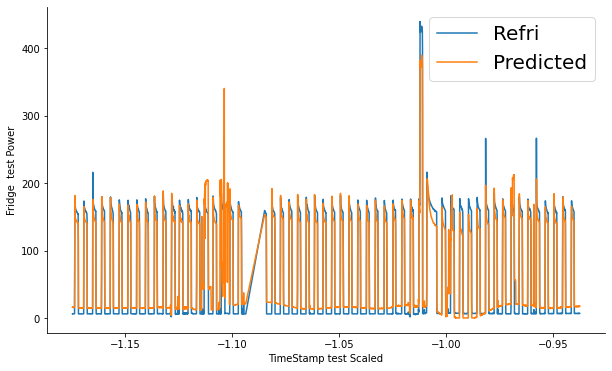

In [24]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[:idx], y_test.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()

In [32]:
for name, params in model.named_parameters():
  print(name, params)

mll.likelihood.noise_covar.raw_noise Parameter containing:
tensor([-1.4866], device='cuda:0', requires_grad=True)
mll.model.mean_module.constant Parameter containing:
tensor([1.5044], device='cuda:0', requires_grad=True)
mll.model.base_covar_module.kernels.0.raw_outputscale Parameter containing:
tensor(-0.1839, device='cuda:0', requires_grad=True)
mll.model.base_covar_module.kernels.0.base_kernel.raw_lengthscale Parameter containing:
tensor([[-1.5998]], device='cuda:0', requires_grad=True)
mll.model.base_covar_module.kernels.1.kernels.0.raw_outputscale Parameter containing:
tensor(-0.5917, device='cuda:0', requires_grad=True)
mll.model.base_covar_module.kernels.1.kernels.0.base_kernel.raw_lengthscale Parameter containing:
tensor([[-1.2250]], device='cuda:0', requires_grad=True)
mll.model.base_covar_module.kernels.1.kernels.1.raw_outputscale Parameter containing:
tensor(-0.5917, device='cuda:0', requires_grad=True)
mll.model.base_covar_module.kernels.1.kernels.1.base_kernel.raw_lengthsc

In [ ]:
model.mll.model.base_covar_module.outputscale

## Decomposition

In [24]:
model1 = SGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel1,
                      inducing_points).to("cuda")

In [25]:
pred_dist1 = model1.predict(x_test_full[:4000].to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


In [26]:
y_pred_arr =[]

y_pred_arr.append(pred_dist1.loc)

In [27]:
y_mean1.shape

torch.Size([4000])

In [28]:
y_pred_arr1 = []
for i in range(len(y_pred_arr)):
  y_pred_arr1.append(np.array(y_pred_arr[i].cpu()))

In [29]:
y_mean1 = np.mean(y_pred_arr1, axis =0)
# y_sigma = np.std(y_pred_arr1, axis=0)

y_mean1.shape#, y_sigma.shape

y_mean1 = scaler_y.inverse_transform(y_mean1.reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_test.shape, y_mean1.shape)

y_mean1 = np.clip(y_mean1,0,y_mean1.max(),out=y_mean1)

torch.Size([15656]) (4000,)


In [30]:
mae = np.mean(np.abs(np.array(y_test[:4000]) - y_mean1))
rms = errors.rmse(jnp.array(y_test[:4000]), y_mean1)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  13.221285980073695
RMSE:  23.772297


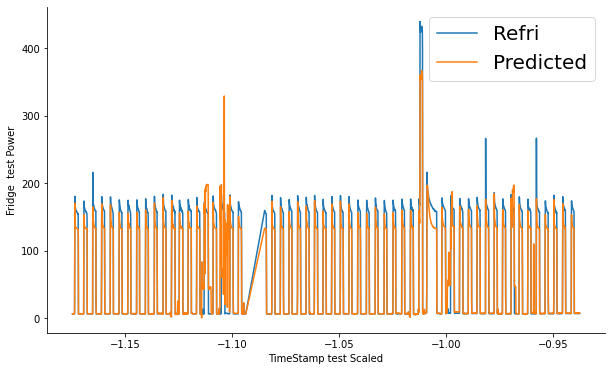

In [31]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[:idx], y_test.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean1[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()

In [17]:
model2 = SGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel2*kernel3,
                      inducing_points).to("cuda")

In [18]:
pred_dist2 = model2.predict(x_test_full[:4000].to("cuda"))
# print("Done ", i)

y_mean2 = pred_dist2.loc

In [19]:
y_pred_arr =[]

y_pred_arr.append(pred_dist2.loc)

In [20]:
y_pred_arr1 = []
for i in range(len(y_pred_arr)):
  y_pred_arr1.append(np.array(y_pred_arr[i].cpu()))

In [21]:
y_mean2 = np.mean(y_pred_arr1, axis =0)
# y_sigma = np.std(y_pred_arr2, axis=0)

y_mean2.shape#, y_sigma.shape

y_mean2 = scaler_y.inverse_transform(y_mean2.reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_test.shape, y_mean2.shape)

y_mean2 = np.clip(y_mean2,0,y_mean2.max(),out=y_mean2)

torch.Size([15656]) (4000,)


In [22]:
mae = np.mean(np.abs(np.array(y_test[:4000]) - y_mean2))
rms = errors.rmse(jnp.array(y_test[:4000]), y_mean2)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  66.97996230941146
RMSE:  83.967285


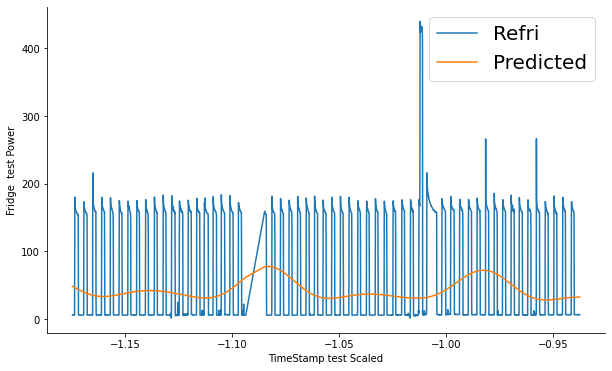

In [23]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[:idx], y_test.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean2[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()